## Multiple features

Combine metrics and events with automatic frequency detection.

In [115]:
from datetime import datetime, timedelta
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import pandas as pd
import numpy as np
import json
import app

def get_metrics(path: str, start: int, end: int, clip: int = 15):
    """Read data files based on date offset start and end."""
    t0 = datetime.now() - timedelta(days=start + 1)
    t1 = datetime.now() - timedelta(days=end)
    df = pd.DataFrame([])
    for file in sorted(Path(path).glob("*.json")):
        date = datetime.strptime(file.stem.split("_")[0], "%Y-%m-%d")
        if date >= t0 and date < t1:
            df = pd.concat([df, pd.read_json(file)], axis=0)
    return app.clip_data(df, clip)


def get_events(path: str, start: int, end: int, ):
    t0 = datetime.now() - timedelta(days=start + 1)
    t1 = datetime.now() - timedelta(days=end)
    # create empty index dataframe
    index_df = pd.DataFrame({"index": np.arange(0, 96, 1)})
    df = pd.DataFrame([])
    for file in sorted(Path(path).glob('*.json')):
        date = datetime.strptime(file.stem.split("_")[0], "%Y-%m-%d")
        if date >= t0 and date < t1:
            data = pd.read_json(file, orient='list')
            data = index_df if data.shape[0] == 0 else data
            data_df = index_df.join(data.set_index('index'), on="index")
            df = pd.concat([df, data_df], axis=0)
    # fill all NaNs with zeros
    return df.fillna(0).drop(columns=['index']).reset_index(drop=True)

In [116]:
def process_events(df: pd.DataFrame):
    # # drop all columns that have only zeroes
    df = df.loc[:, (df != 0).any(axis=0)]
    # convert to 'how long ago' in days
    df = (df / (60 * 60 * 24))
    # filter
    # success = [c for c in df if c.split("_")[0] == "success"]
    errors = [c for c in df if c.split("_")[0] == "error"]
    warnings = [c for c in df if c.split("_")[0] == "warning"]
    # higher values mean higher risk, values closer to zero mean no risk
    return df[[*errors, *warnings]]
    # return np.round(np.power(df[[*errors, *warnings]], 3), 4)
    # return np.tanh(df[[*errors, *warnings]])

In [117]:
# load events features, describe non-zero data
df_events = process_events(get_events("metrics/events", 15, 0))
print(df_events.shape)
df_events.describe()

(1344, 13)


,error_web_api_5xx_error_response_is_high,error_discord_server_down,error_there_are_elevated_cluster_errors,error_discord_bot_exploded,error_midjourney_website_low_traffic,error_midjourney_job_submission_halted,error_/describe_is_down,warning_web_api_5xx_error_response_is_high,warning_discord_server_down,warning_there_are_elevated_cluster_errors,warning_discord_bot_exploded,warning_midjourney_website_low_traffic,warning_midjourney_job_submission_halted
count,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1.344000e+03,1344.000000
mean,0.060526,0.000010,0.037400,0.089705,0.000010,0.015009,0.000080,0.074547,0.056706,0.095418,0.047021,9.989528e-07,0.013157
std,0.197057,0.000331,0.145247,0.231720,0.000287,0.103363,0.001594,0.216088,0.186953,0.245167,0.171892,3.662222e-05,0.093716
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
max,0.989630,0.012025,0.997049,0.996157,0.009687,0.996343,0.042442,0.999340,0.999525,0.998449,0.997535,1.342593e-03,0.996331


In [118]:
# load metrics features
df_metrics = get_metrics("metrics/relax", 15, 0)
df_metrics

,kdpt_diffusion_anime,v4_anime_upscaler,v4_diffusion,v4_upscaler,v5_diffusion,v5_diffusion_anime
0,0.035200,0.023499,0.575200,9.074800,2.108701,4.983200
1,0.022700,0.019799,0.719101,7.371600,2.209400,5.776600
2,0.012100,0.014000,1.395300,6.346701,2.495200,6.021700
3,0.052701,0.067001,2.188499,6.194799,2.982100,6.156300
4,0.055100,0.074201,5.199800,5.564800,3.454800,6.631900
...,...,...,...,...,...,...
1339,2.056500,2.653500,3.090800,0.747399,0.648000,2.572001
1340,2.259800,2.522700,2.930099,1.318901,0.596100,3.066700
1341,2.710000,2.649700,2.926200,3.349600,0.606201,3.404600
1342,2.727700,2.850300,2.292700,6.243401,0.626600,3.211700


In [119]:
# combine all data
df = df_metrics.join(df_events)
df

,kdpt_diffusion_anime,v4_anime_upscaler,v4_diffusion,v4_upscaler,v5_diffusion,v5_diffusion_anime,error_web_api_5xx_error_response_is_high,error_discord_server_down,error_there_are_elevated_cluster_errors,error_discord_bot_exploded,error_midjourney_website_low_traffic,error_midjourney_job_submission_halted,error_/describe_is_down,warning_web_api_5xx_error_response_is_high,warning_discord_server_down,warning_there_are_elevated_cluster_errors,warning_discord_bot_exploded,warning_midjourney_website_low_traffic,warning_midjourney_job_submission_halted
0,0.035200,0.023499,0.575200,9.074800,2.108701,4.983200,0.144491,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.022700,0.019799,0.719101,7.371600,2.209400,5.776600,0.154907,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.111331,0.0,0.0,0.0,0.0
2,0.012100,0.014000,1.395300,6.346701,2.495200,6.021700,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.101412,0.000000,0.0,0.0,0.0,0.0
3,0.052701,0.067001,2.188499,6.194799,2.982100,6.156300,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.169479,0.000000,0.0,0.0,0.0,0.0
4,0.055100,0.074201,5.199800,5.564800,3.454800,6.631900,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.122257,0.142581,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1339,2.056500,2.653500,3.090800,0.747399,0.648000,2.572001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1340,2.259800,2.522700,2.930099,1.318901,0.596100,3.066700,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1341,2.710000,2.649700,2.926200,3.349600,0.606201,3.404600,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1342,2.727700,2.850300,2.292700,6.243401,0.626600,3.211700,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


In [120]:
# store data features to constraint new data
df_frame = df.iloc[0:0]
df_frame.to_csv('df_frame.csv', index=False)
df_frame

,kdpt_diffusion_anime,v4_anime_upscaler,v4_diffusion,v4_upscaler,v5_diffusion,v5_diffusion_anime,error_web_api_5xx_error_response_is_high,error_discord_server_down,error_there_are_elevated_cluster_errors,error_discord_bot_exploded,error_midjourney_website_low_traffic,error_midjourney_job_submission_halted,error_/describe_is_down,warning_web_api_5xx_error_response_is_high,warning_discord_server_down,warning_there_are_elevated_cluster_errors,warning_discord_bot_exploded,warning_midjourney_website_low_traffic,warning_midjourney_job_submission_halted


## Features

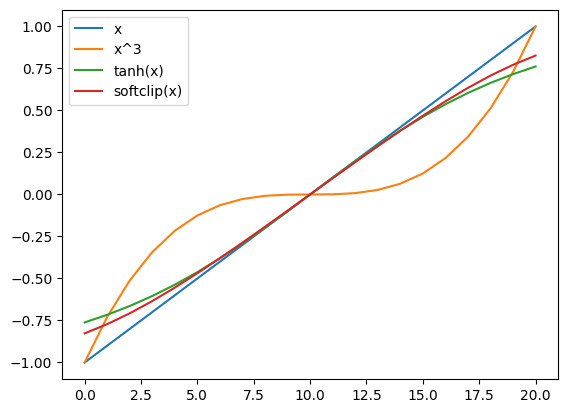

In [121]:
# comparing functions in case of transforming data
x = np.arange(-1, 1.1, 0.1)
plt.plot(x)
plt.plot(np.power(x, 3))
plt.plot(np.tanh(x))
plt.plot(
    tfp.bijectors.SoftClip(low=-1, high=1, hinge_softness=0.25)
    .forward(x)
    .numpy()
)
plt.legend(["x", "x^3", "tanh(x)", "softclip(x)"])

/var/folders/1c/66th25rx3059qwtmh9gh_hsc0000gn/T/ipykernel_62858/2979064915.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,frequency,amplitude
hour,,
24.0,7.00,323.862099
168.0,1.00,256.865121
5.0,31.00,183.051825
84.0,2.00,181.946424
67.0,2.50,167.591176
112.0,1.50,155.640921
12.0,13.50,153.321889
33.0,5.00,145.636508
4.0,38.00,140.818962


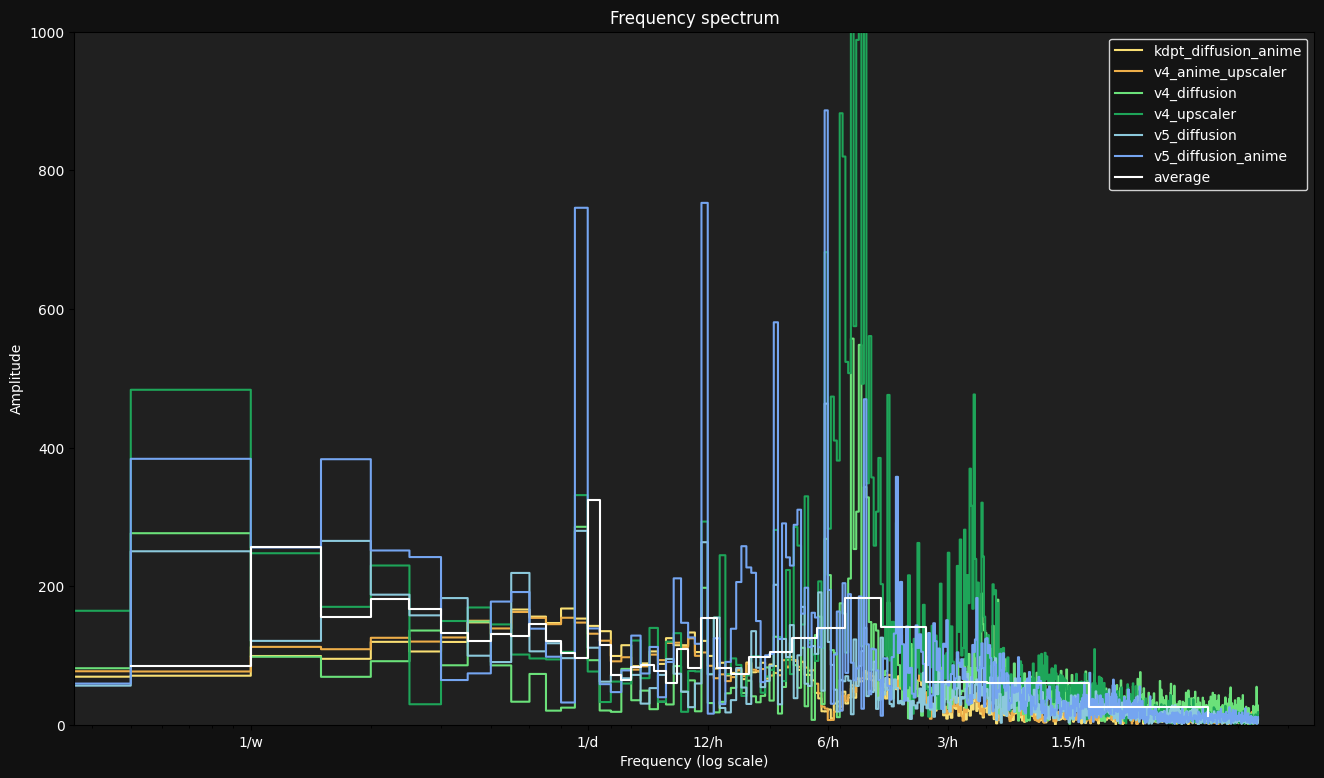

In [122]:
from scipy import signal

# select columns
cols = df.columns[0:6]
# create cumulative arrays
amplitude, frequency = np.asarray([]), np.asarray([])
# create high pass filter to reduce recency noise
highpass_soft = signal.butter(1, 3.5, 'hp', fs=1000, output='sos')
highpass_hard = signal.butter(12, 1, 'hp', fs=1000, output='sos')
# plot
fig, ax =  plt.subplots(figsize=(16, 9), dpi=100, facecolor='#111111', edgecolor='#eeeeee')
colors = ["#F9DF74", "#EDAE49", "#6BE17A", "#1EA559", "#8cc9dc", "#75A5F0"]
for i, col in enumerate(cols):
    # apply filter and compute fft
    filtered = df[col]
    # filtered = signal.sosfilt(highpass_soft, filtered)
    filtered = signal.sosfilt(highpass_hard, filtered)
    fft = tf.signal.rfft(filtered)
    f_per_dataset = np.arange(0, len(fft))
    # compute freqs
    n_samples_15min = df.shape[0]
    n_15min_per_week = 96 * 7
    weeks_per_dataset = n_samples_15min/n_15min_per_week
    f_per_week = f_per_dataset/weeks_per_dataset
    # append to numpy array, skip first element (DC component)
    frequency = np.concatenate((frequency, f_per_week[1:]))
    amplitude = np.concatenate((amplitude, np.abs(fft[1:])))
    # plot
    ax.set_facecolor('#202020')
    ax.step(f_per_week, np.abs(fft), color=colors[i], label=df.columns[i])
    ax.set_xscale('log')
    ax.set_xticks([1, 7, 7 * 2, 7 * 4, 7 * 8, 7 * 16], labels=['1/w', '1/d', '12/h', '6/h', '3/h', '1.5/h'], color="#ffffff")
    ax.set_yticks([0, 200, 400, 600, 800, 1000], labels=['0', '200', '400', '600', '800', '1000'], color="#ffffff")
    ax.set_ylim(0, 1000)
    ax.set_xlabel('Frequency (log scale)', color="#ffffff")
    ax.set_ylabel('Amplitude', color="#ffffff")
    ax.set_title('Frequency spectrum', color="#ffffff")

# convert frequency to time domain, hours, use sample resolution of 15min
hour = (15 * 24 * 7 * (1 / frequency)) // 15
# hour = np.round(24 * 7 * (1 / frequency), 0)
mean_fft = pd.DataFrame({"frequency": frequency, "amplitude": amplitude, "hour": hour}).groupby("hour").agg(np.mean)
# plot rest of data
ax.step(mean_fft['frequency'], mean_fft['amplitude'], color="#ffffff", label='average')
l = ax.legend([*cols, 'average'], loc='upper right', facecolor='#111111', edgecolor='#ffffff')
for text in l.get_texts():
    text.set_color("#ffffff")
fig.show()
# get highest average frequencies
top_hours = mean_fft.sort_values('amplitude', ascending=False).iloc[0:10]
top_hours

In [123]:
df = app.add_time_features(df, top_hours.index)
df

,kdpt_diffusion_anime,v4_anime_upscaler,v4_diffusion,v4_upscaler,v5_diffusion,v5_diffusion_anime,error_web_api_5xx_error_response_is_high,error_discord_server_down,error_there_are_elevated_cluster_errors,error_discord_bot_exploded,...,112.0_hours_sin,112.0_hours_cos,12.0_hours_sin,12.0_hours_cos,33.0_hours_sin,33.0_hours_cos,4.0_hours_sin,4.0_hours_cos,6.0_hours_sin,6.0_hours_cos
0,0.035200,0.023499,0.575200,9.074800,2.108701,4.983200,0.144491,0.0,0.0,0.0,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000e+00,0.000000,1.000000
1,0.022700,0.019799,0.719101,7.371600,2.209400,5.776600,0.154907,0.0,0.0,0.0,...,0.014025,0.999902,0.130526,0.991445,0.047582,0.998867,0.382683,9.238795e-01,0.258819,0.965926
2,0.012100,0.014000,1.395300,6.346701,2.495200,6.021700,0.000000,0.0,0.0,0.0,...,0.028046,0.999607,0.258819,0.965926,0.095056,0.995472,0.707107,7.071068e-01,0.500000,0.866025
3,0.052701,0.067001,2.188499,6.194799,2.982100,6.156300,0.000000,0.0,0.0,0.0,...,0.042062,0.999115,0.382683,0.923880,0.142315,0.989821,0.923880,3.826834e-01,0.707107,0.707107
4,0.055100,0.074201,5.199800,5.564800,3.454800,6.631900,0.000000,0.0,0.0,0.0,...,0.056070,0.998427,0.500000,0.866025,0.189251,0.981929,1.000000,6.123234e-17,0.866025,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1339,2.056500,2.653500,3.090800,0.747399,0.648000,2.572001,0.000000,0.0,0.0,0.0,...,0.070067,-0.997542,-0.608761,0.793353,0.327068,0.945001,-0.923880,-3.826834e-01,-0.965926,0.258819
1340,2.259800,2.522700,2.930099,1.318901,0.596100,3.066700,0.000000,0.0,0.0,0.0,...,0.056070,-0.998427,-0.500000,0.866025,0.371662,0.928368,-1.000000,9.314124e-15,-0.866025,0.500000
1341,2.710000,2.649700,2.926200,3.349600,0.606201,3.404600,0.000000,0.0,0.0,0.0,...,0.042062,-0.999115,-0.382683,0.923880,0.415415,0.909632,-0.923880,3.826834e-01,-0.707107,0.707107
1342,2.727700,2.850300,2.292700,6.243401,0.626600,3.211700,0.000000,0.0,0.0,0.0,...,0.028046,-0.999607,-0.258819,0.965926,0.458227,0.888835,-0.707107,7.071068e-01,-0.500000,0.866025


In [124]:
models = {}
models["dense"] = app.get_multidense_model
models["cnn"] = app.get_convolution_model
models["lstm"] = app.get_lstm_model
models['feedback'] = app.get_feedback_model

In [125]:
# params
steps = 96
selected = "dense"
model: app.Model = models[selected](df.shape[1], steps)
# perf
perf = []
windows = []
history = []
for train, val, test in app.generate_sliding_window(population_size=df.shape[0], sample_size=steps, cycles=3):
    train_df, val_df, test_df, std, mean = app.normalize_training_data(
        df.iloc[train], df.iloc[val], df.iloc[test]
    )
    print(train.shape, val.shape, test.shape, train[0], val[0], test[0])
    window = app.WindowGenerator(
        train_df, val_df, test_df, input_width=steps, label_width=steps, shift=steps
    )
    h = app.compile_and_fit(model, window, patience=10, max_epocs=20)
    perf.append({"val": model.evaluate(window.val, verbose=0)[1], "test": model.evaluate(window.test, verbose=0)[1]})
    windows.append({"window": window, "model": model})
    history.append(h.history)
# output
print(pd.DataFrame(perf))
print(sum(p["val"] for p in perf) / len(perf))
print(sum(p["test"] for p in perf) / len(perf))

(768,) (192,) (192,) 0 768 960
(768,) (192,) (192,) 96 864 1056
(768,) (192,) (192,) 192 960 1152
        val      test
0  0.140825  0.227471
1  0.160939  0.453226
2  0.252703  1.887813
0.18482253948847452
0.8561701873938242


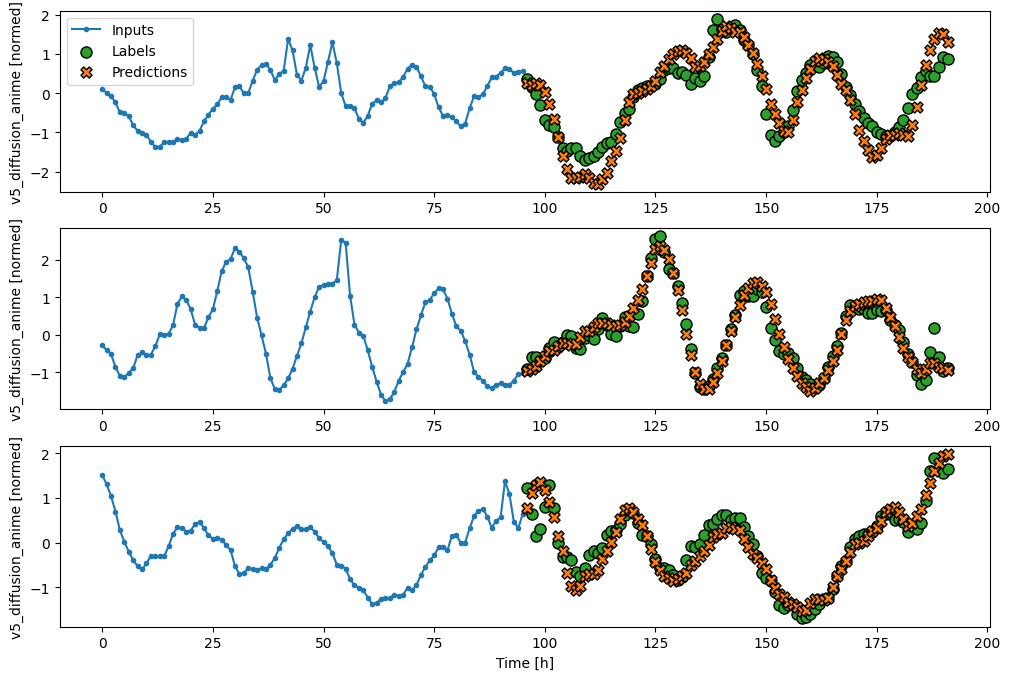

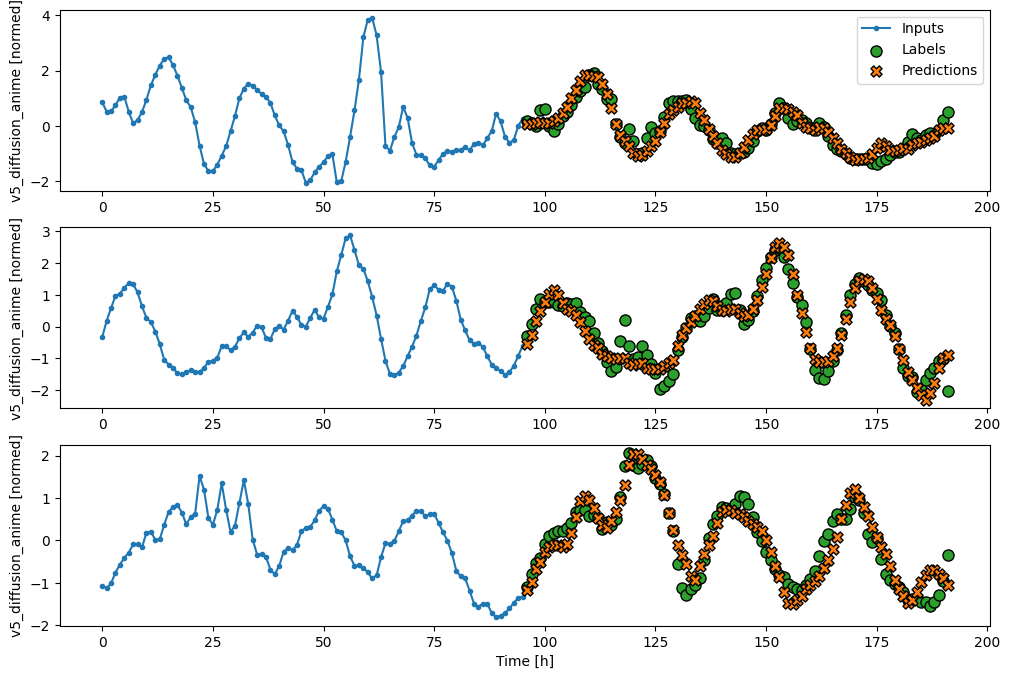

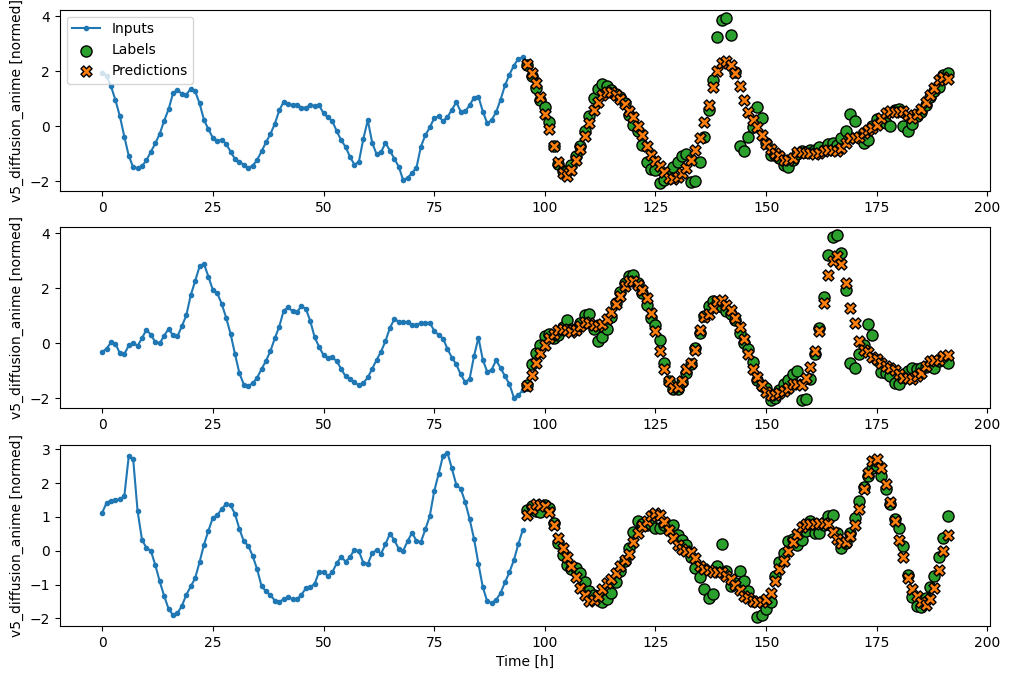

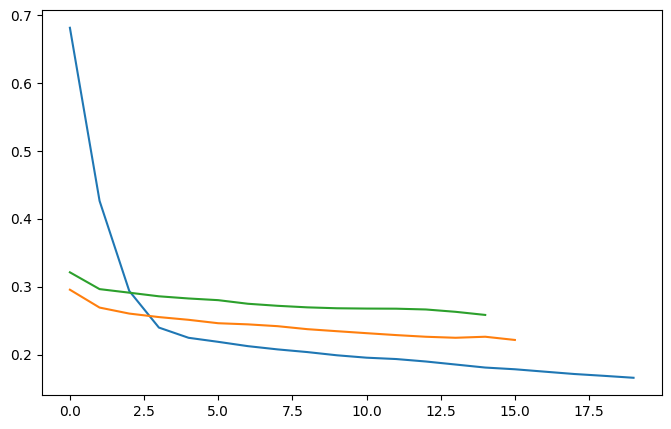

In [126]:
# plot windows
for win in windows:
    win["window"].plot(model=win["model"], plot_col=df.columns[5])
# loss
fig, ax = plt.subplots(figsize=(8, 5))
for h in history:
    ax.plot(h['loss'])
# save
model.save(f"model.h5")
model = app.load_model(f"model.h5")

In [127]:
df_frame = pd.DataFrame(0, index=np.arange(96), columns=pd.read_csv('df_frame.csv').columns)
df_frame

,kdpt_diffusion_anime,v4_anime_upscaler,v4_diffusion,v4_upscaler,v5_diffusion,v5_diffusion_anime,error_web_api_5xx_error_response_is_high,error_discord_server_down,error_there_are_elevated_cluster_errors,error_discord_bot_exploded,error_midjourney_website_low_traffic,error_midjourney_job_submission_halted,error_/describe_is_down,warning_web_api_5xx_error_response_is_high,warning_discord_server_down,warning_there_are_elevated_cluster_errors,warning_discord_bot_exploded,warning_midjourney_website_low_traffic,warning_midjourney_job_submission_halted
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
92,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
93,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
94,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [128]:
days = 7
metrics = get_metrics("metrics/relax", days, 0)
events = process_events(get_events("metrics/events", days, 0))
print(metrics.shape, events.shape)
# fill the frame with metrics and events, using columns that exist in both
df_frame[list(set(metrics.columns) - (set(metrics.columns) - set(df_frame.columns)))] = metrics
df_frame[list(set(events.columns) - (set(events.columns) - set(df_frame.columns)))] = events
df_frame

(768, 6) (768, 13)


,kdpt_diffusion_anime,v4_anime_upscaler,v4_diffusion,v4_upscaler,v5_diffusion,v5_diffusion_anime,error_web_api_5xx_error_response_is_high,error_discord_server_down,error_there_are_elevated_cluster_errors,error_discord_bot_exploded,error_midjourney_website_low_traffic,error_midjourney_job_submission_halted,error_/describe_is_down,warning_web_api_5xx_error_response_is_high,warning_discord_server_down,warning_there_are_elevated_cluster_errors,warning_discord_bot_exploded,warning_midjourney_website_low_traffic,warning_midjourney_job_submission_halted
0,1.595900,0.0874,1.246400,0.052800,4.357600,2.077901,0.000000,0.000000,0.0,0.0,0.000000,0.012037,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
1,1.492000,0.0522,1.391000,0.057000,4.904301,3.418800,0.000000,0.004213,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
2,2.216900,0.0082,1.296400,0.012500,5.398800,5.770599,0.000000,0.014630,0.0,0.0,0.000000,0.000000,0.0,0.000532,0.0,0.000000,0.0,0.000000,0.0
3,1.193901,0.1393,0.789800,0.262399,4.927500,8.086600,0.000000,0.025046,0.0,0.0,0.000000,0.043287,0.0,0.004005,0.0,0.000000,0.0,0.000000,0.0
4,0.303200,0.1696,0.258500,0.218000,4.858200,8.919200,0.000000,0.035463,0.0,0.0,0.000000,0.053704,0.0,0.014421,0.0,0.001007,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,4.496600,0.0262,1.954701,0.042300,5.520700,2.755100,0.000000,0.925729,0.0,0.0,0.926921,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.103785,0.0
92,2.304200,0.4073,1.131001,0.005101,6.052800,1.586700,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
93,0.152901,0.4273,0.224200,0.002301,5.387800,1.137399,0.000000,0.962546,0.0,0.0,0.124155,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.153785,0.0
94,2.721600,0.0028,0.401299,0.001600,5.390900,2.098700,0.000000,0.000000,0.0,0.0,0.000000,0.991204,0.0,0.951921,0.0,0.000000,0.0,0.000000,0.0


In [129]:
df_x = (app.add_time_features(df_frame, top_hours.index) - mean) / std
df_x

,kdpt_diffusion_anime,v4_anime_upscaler,v4_diffusion,v4_upscaler,v5_diffusion,v5_diffusion_anime,error_web_api_5xx_error_response_is_high,error_discord_server_down,error_there_are_elevated_cluster_errors,error_discord_bot_exploded,...,112.0_hours_sin,112.0_hours_cos,12.0_hours_sin,12.0_hours_cos,33.0_hours_sin,33.0_hours_cos,4.0_hours_sin,4.0_hours_cos,6.0_hours_sin,6.0_hours_cos
0,5.718022,0.249770,-0.836584,-1.226780,1.587769,-1.159097,-0.308992,0.000000,-0.279304,-0.442818,...,-0.244033,1.528180,-7.753412e-17,1.413293,0.048918,1.349443,3.014595e-17,1.413293e+00,-3.636646e-17,1.413293
1,5.332847,0.048217,-0.744878,-1.225628,1.993677,-0.477837,-0.308992,0.004213,-0.279304,-0.442818,...,-0.222737,1.528045,1.844717e-01,1.401202,0.117332,1.347866,5.408436e-01,1.305712e+00,3.657870e-01,1.365136
2,8.020179,-0.203727,-0.804873,-1.237830,2.360827,0.717024,-0.308992,0.014630,-0.279304,-0.442818,...,-0.201445,1.527640,3.657870e-01,1.365136,0.185591,1.343136,9.993487e-01,9.993487e-01,7.066463e-01,1.223947
3,4.227744,0.546945,-1.126163,-1.169310,2.010902,1.893697,-0.308992,0.025046,-0.279304,-0.442818,...,-0.180162,1.526964,5.408436e-01,1.305712,0.253540,1.335266,1.305712e+00,5.408436e-01,9.993487e-01,0.999349
4,0.925758,0.720436,-1.463118,-1.181484,1.959449,2.316710,-0.308992,0.035463,-0.279304,-0.442818,...,-0.158891,1.526018,7.066463e-01,1.223947,0.321026,1.324273,1.413293e+00,2.136067e-16,1.223947e+00,0.706646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,16.471426,-0.100657,-0.387373,-1.229659,2.451335,-0.815038,-0.308992,0.925729,-0.279304,-0.442818,...,1.209065,0.552620,-8.603580e-01,1.121240,-1.285903,-0.561083,-1.305712e+00,-5.408436e-01,-1.365136e+00,0.365787
92,8.343816,2.081491,-0.909771,-1.239858,2.846403,-1.408658,-0.308992,0.000000,-0.279304,-0.442818,...,1.215104,0.534134,-7.066463e-01,1.223947,-1.309818,-0.498970,-1.413293e+00,-4.373846e-15,-1.223947e+00,0.706646
93,0.368573,2.196012,-1.484871,-1.240626,2.352661,-1.636931,-0.308992,0.962546,-0.279304,-0.442818,...,1.220856,0.515572,-5.408436e-01,1.305712,-1.330655,-0.435824,-1.305712e+00,5.408436e-01,-9.993487e-01,0.999349
94,9.891189,-0.234646,-1.372553,-1.240818,2.354962,-1.148530,-0.308992,0.000000,-0.279304,-0.442818,...,1.226320,0.496939,-3.657870e-01,1.365136,-1.348367,-0.371790,-9.993487e-01,9.993487e-01,-7.066463e-01,1.223947


1/1 [==============================] - 0s 138ms/step
(1, 96, 39)


,kdpt_diffusion_anime,v4_anime_upscaler,v4_diffusion,v4_upscaler,v5_diffusion,v5_diffusion_anime
0,0.507234,0.127229,1.383775,2.832134,4.098309,4.308425
1,0.000000,0.000000,3.657856,3.351236,2.995581,6.255618
2,0.000000,0.000000,5.150780,4.048511,2.192859,7.911736
3,0.000000,0.000000,6.156225,4.693071,1.187460,8.781210
4,0.000000,0.000000,6.314890,4.722378,0.977188,8.787051
...,...,...,...,...,...,...
91,0.056320,0.025447,0.278354,7.795479,1.757935,4.735151
92,0.000000,0.070890,0.000000,10.278668,1.414235,5.467628
93,0.004189,0.115057,0.000000,12.066404,1.560896,6.053144
94,0.000000,0.036154,0.000000,13.512765,1.753693,5.833639


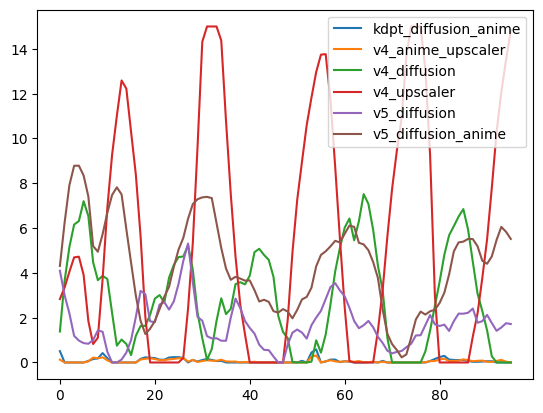

In [130]:
y_pred = model.predict(app.get_predict_window_dataset(df_x[-96:]))
print(y_pred.shape)
y = y_pred[0, :, 0:6] * std[0:6].values + mean[0:6].values
y = app.clip_data(y)
y_df = pd.DataFrame(y, columns=df.columns[0:6])
plt.plot(y)
plt.legend(y_df.columns[0:6])
y_df